### Problem 3:

This is my second adaption of the notebook provided here: 

https://colab.research.google.com/drive/1F-RWvoxH8MmT7c1UmNy41iuOp-ejiLoF#scrollTo=KSrgMJ5vKFzQ&forceEdit=true&sandboxMode=true.



# Fine-tuning VGG16 

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the VGG16 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 19:44:39--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 2404:6800:4008:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  71.4MB/s    in 0.9s    

2020-04-21 19:44:40 (71.4 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with Xception convolution base and custom densely connected layers

### Load the convolutional base

In [4]:
from keras.applications import Xception

conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

conv_base.summary()

Using TensorFlow backend.


83689472/83683744 [==============================] - 6s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
__________________________

### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 33,969,193
Trainable params: 13,107,713
Non-trainable params: 20,861,480
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 25s 255ms/step - loss: 0.4716 - acc: 0.7675 - val_loss: 0.2866 - val_acc: 0.9420
Epoch 2/30
100/100 [==============================] - 17s 169ms/step - loss: 0.3824 - acc: 0.8215 - val_loss: 0.1207 - val_acc: 0.9520
Epoch 3/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3679 - acc: 0.8340 - val_loss: 0.2171 - val_acc: 0.9590
Epoch 4/30
100/100 [==============================] - 17s 169ms/step - loss: 0.3090 - acc: 0.8605 - val_loss: 0.0055 - val_acc: 0.9680
Epoch 5/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3387 - acc: 0.8465 - val_loss: 0.0111 - val_acc: 0.9710
Epoch 6/30
100/100 [==============================] - 17s 168ms/step - loss: 0.3475 - acc: 0.8385 - val_loss: 0.2770 - val_acc: 0.9670
Epoch 7/30
100/100 [==============================] - 17s 170ms/step - loss: 0.3228 - acc: 0.8545 - val_lo

## Display curves of loss and accuracy during training

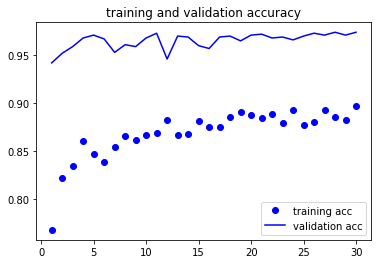

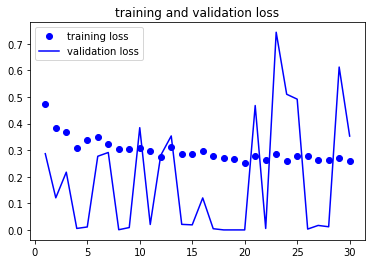

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

The idea here is that we only want to unfreeze the last convolutional layer, which the conv_base summary has shown to be conv2d_4. This means that we only want all layers starting here to be trainable, but everything beforehand is to stay as it was originally. We only start training from this layer as it helps prevent overfitting; if we were to do this from an earlier convolutional layer, the number of parameters we're using results can result in this occuring. 

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'conv2d_4':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [11]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 21s 208ms/step - loss: 0.2553 - acc: 0.8890 - val_loss: 0.6595 - val_acc: 0.9380
Epoch 2/100
100/100 [==============================] - 17s 173ms/step - loss: 0.2348 - acc: 0.9040 - val_loss: 0.1561 - val_acc: 0.9430
Epoch 3/100
100/100 [==============================] - 17s 173ms/step - loss: 0.2173 - acc: 0.9060 - val_loss: 0.2258 - val_acc: 0.9160
Epoch 4/100
100/100 [==============================] - 17s 173ms/step - loss: 0.2370 - acc: 0.9040 - val_loss: 0.5289 - val_acc: 0.9340
Epoch 5/100
100/100 [==============================] - 17s 173ms/step - loss: 0.2000 - acc: 0.9200 - val_loss: 0.0234 - val_acc: 0.9340
Epoch 6/100
100/100 [==============================] - 17s 173ms/step - loss: 0.2256 - acc: 0.9035 - val_loss: 0.5462 - val_acc: 0.9230
Epoch 7/100
100/100 [==============================] - 18s 175ms/step - loss: 0.2153 - acc: 0.9080 - val_loss: 0.0447 - val_acc: 0.9330
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

To display the data, we shall curve the function by utilizing the function "smooth_curve," provided in chapter 5.3 of "Deep Learning with Python."

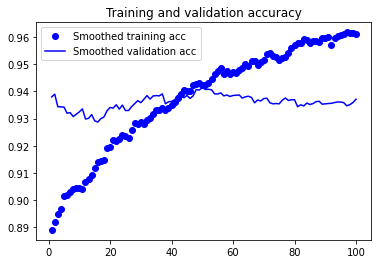

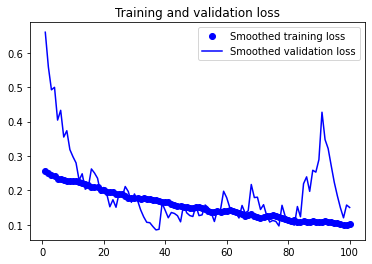

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, smooth_curve(acc), "bo", label="Smoothed training acc")
plt.plot(epochs, smooth_curve(val_acc), "b", label="Smoothed validation acc")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(loss), "bo", label="Smoothed training loss")
plt.plot(epochs, smooth_curve(val_loss), "b", label="Smoothed validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

# # training and validation accuracy

# plt.plot(epochs, acc, 'bo', label='training acc')
# plt.plot(epochs, val_acc, 'b', label='validation acc')
# plt.title('training and validation accuracy')
# plt.legend()

# plt.figure()

# # training and validation loss

# plt.plot(epochs, loss, 'bo', label='training loss')
# plt.plot(epochs, val_loss, 'b', label='validation loss')
# plt.title('training and validation loss')
# plt.legend()

plt.show()

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [14]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.6802034974098206
Validation accuracy: 0.9419999718666077


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)